# Bloque 1: Introducción al Aprendizaje Automático

In [1]:
%pylab
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


## Creación de modelos de regresión lineal básicos
En `scikit-learn` los modelos de regresión lineal se implementa con la clase `LinearRegression`. En el siguiente ejemplo se muestra los pasos necesarios para conseguir una regresión lineal.

In [2]:
from sklearn.linear_model import LinearRegression
    
# Conjunto de datos
x = [[80], [79], [83], [84], [78], [60], [82], [85], [79], [84], [80], [62]]
y = [[300], [302], [315], [330], [300], [250], [300], [340], [315], [330], [310], [240]]

# Creación del modelo
model = LinearRegression()
model.fit(x, y)

# Obtención de estimaciones
print('Con 70 horas la producción sería:', model.predict([[70]]))
print()

# Obtención de los parametros de ajuste
print('beta_0', model.intercept_[0])
print('beta_1', model.coef_[0][0])
print('R^2', model.score(x, y))

Con 70 horas la producción sería: [[274.87943262]]

beta_0 31.741134751773075
beta_1 3.473404255319149
R^2 0.9101048533632331


In [4]:
model.intercept_

array([31.74113475])

### Representación gráfica del modelo
La calidad del ajuste se puede analizar visualmente al comparar los datos utilizados con las predicciones que se obtienen del modelo.

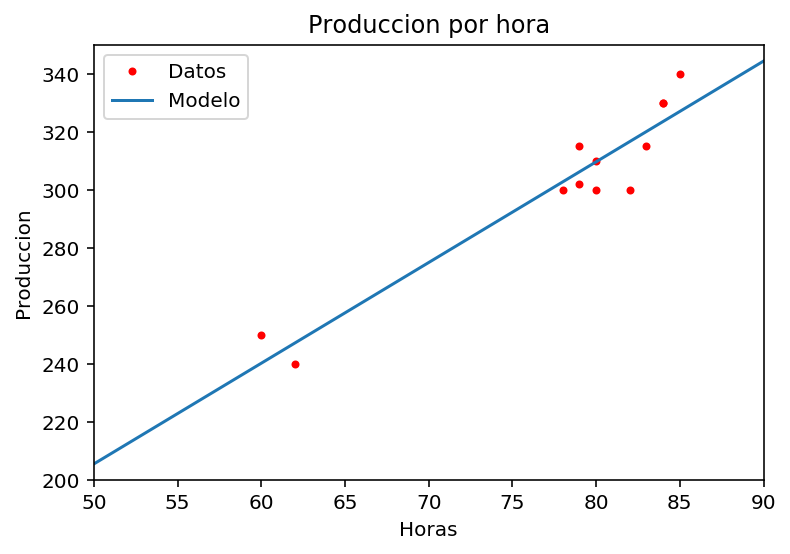

In [3]:
x_p = [[50], [350]]
y_p = model.predict(x_p)

plot(x, y, 'r.', label = 'Datos')
plot(x_p, y_p, label = 'Modelo')

title('Produccion por hora')
xlabel('Horas')
ylabel('Produccion')
axis([50, 90, 200, 350])

legend(loc = 2)

### Eliminación del término independiente
Al analizar los resultados de este ajuste se puede observar que el término independiente es mayor que cero. Teniendo en cuenta que el modelo utilizado es de la forma:

$$y = w_0 + w_1 x$$

Esto índica que el modelo implementado no realiza una estimación correcta cuando se trabajan 0 horas, ya que en este caso la producción esperada sería igual al valor del término independiente. La solución de este problema se puede obtener haciendo un modelo en el que no exista término independiente.

In [4]:
# Modelo sin término de independiente
model_ni = LinearRegression(fit_intercept = False)
model_ni.fit(x, y)

# Obtención de estimaciones
print('Con 70 horas la producción sería:', model_ni.predict([[70]])[0])
print('')

# Obtención de los parametros de ajuste
print('beta_0', model_ni.intercept_)
print('beta_1', model_ni.coef_[0][0])
print('R^2', model_ni.score(x, y))

Con 70 horas la producción sería: [271.3335141]

beta_0 0.0
beta_1 3.8761930585683295
R^2 0.8977400845135438


Una forma de comparar la validez de los dos modelos es mediante la representación grafica de las predicciones de ambos y los datos en una misma figura.

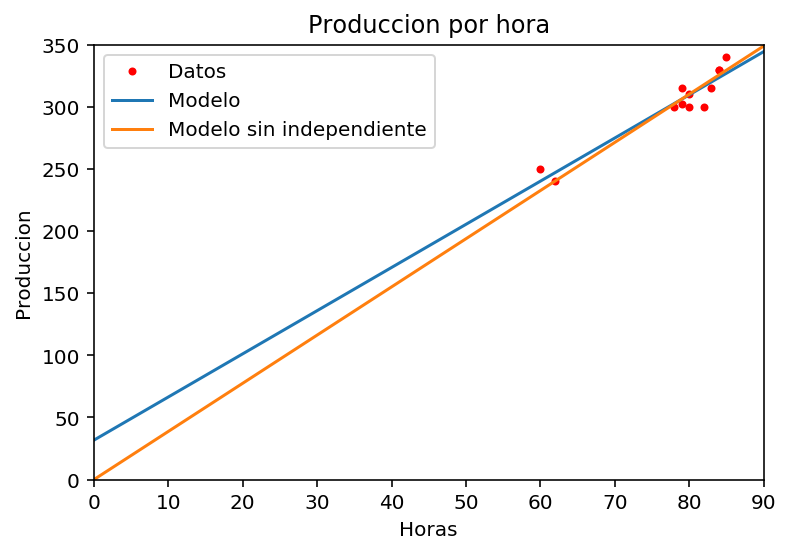

In [5]:
x_p = [[0], [350]]
y_p = model.predict(x_p)

plot(x, y, 'r.', label = 'Datos')
plot(x_p, y_p, label = 'Modelo')
plot(x_p, model_ni.predict(x_p), label = 'Modelo sin independiente')

title('Produccion por hora')
xlabel('Horas')
ylabel('Produccion')
axis([0, 90, 0, 350])

legend(loc = 2)

## Gradiente Descendente
El objetivo de la regresión lineal es ajustar una linea a un conjunto de puntos utilizando una expresión del estilo

$$y = w_0 + w_1 x$$

Como ejemplo se puede crear un conjunto de datos con $w_0 = 3$ y $w_1 = 2$ al que se le añade ruido

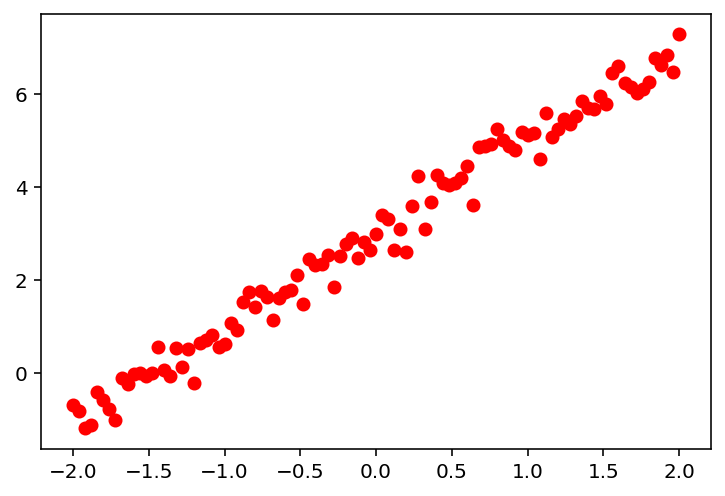

In [6]:
trX = np.linspace(-2, 2, 101)
trY = 3 + 2 * trX + np.random.randn(*trX.shape) * 0.33

scatter(trX, trY, color = 'r')

### Función de error
Para obtener la mejor recta que reproduce el conjunto de datos se ha de definir una función de error (también llamada función de coste) que indique lo buena que es la generada por un conjunto de parámetros ($\beta_0$ y $\beta_1$). Una función utilizada es el error cuadrático medio, es decir:

$$ J(w_0,w_1) = \frac{1}{N} \sum_{i=1}^N \left(y_i -(w_0 + w_1 x_i) \right)^2. $$

Una implementación de esta expresión se puede observar en la siguiente función:

In [7]:
def computeLinealRegressionError(w0, w1, x, y):
    totalError = 0
    for i in range(0, len(x)):
        totalError += (y[i] - (w0 + w1 * x[i])) ** 2
    return totalError / float(len(x))

El valor más bajo que devuelve este método se obtiene cuando los parámetros son iguales a los utilizados en la simulación. (Al añadir ruido en la simulación el mínimo valor no corresponderá exactamente con el de los parámetros utilizados pero estará bastante cerca.)

In [8]:
print("Resultado con (3, 2):", computeLinealRegressionError(3, 2, trX, trY))
print("Resultado con (5, 2):", computeLinealRegressionError(5, 2, trX, trY))
print("Resultado con (3, 5):", computeLinealRegressionError(3, 5, trX, trY))

Resultado con (3, 2): 0.09716540472376434
Resultado con (5, 2): 4.1852134102161225
Resultado con (3, 5): 12.296467468275118


La situación del mínimo se puede apreciar mejor al representar la función de error frente a los parámetros en un gráfica.

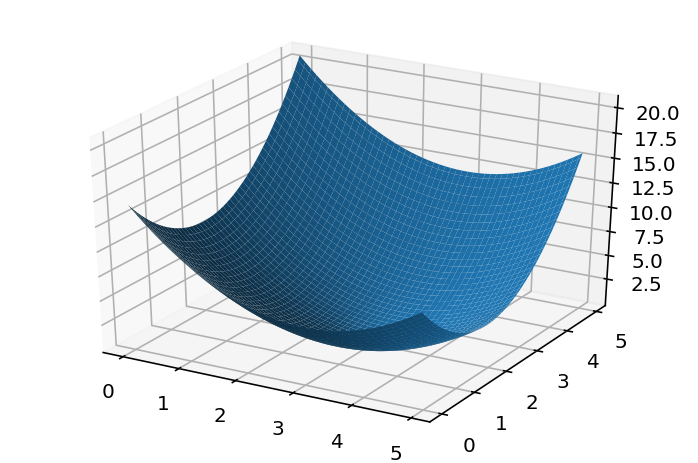

In [9]:
from mpl_toolkits.mplot3d import Axes3D

w0 = np.arange(0, 5, 0.05)
w1 = np.arange(0, 5, 0.05)
X, Y = np.meshgrid(w0, w1)
    
zs = np.array([computeLinealRegressionError(x, y, trX, trY) for x, y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

figure().add_subplot(111, projection = '3d').plot_surface(X, Y, Z)

Cada uno de los puntos en este espacio bidimensional representa una posible línea y la altura de la función en cada punto es el valor de su error. Una forma de obtener el punto en el que se hace mínima la altura es comenzar en un punto aleatorio y desplazarse en la dirección indicada por el gradiente. Este método es el que se conoce como *Gradiente Descendente*.

### Gradiente Descendente
Para ejecutar el método de gradiente descendente para la función de error, primero se ha de calcular el gradiente. La forma para calcularlo es obtener las derivadas parciales de la función de error respecto a los parámetros ($w_0$ y $w_1$). Estas derivadas son:

$$ \frac{\partial J(w_0,w_1)}{\partial w_0} = - \frac{2}{N} \sum_{i=1}^N \left(y_i -(w_0 + w_1 x_i) \right) $$

y

$$ \frac{\partial J(w_0,w_1)}{\partial w_1} = - \frac{2}{N} \sum_{i=1}^N x_i \left(y_i -(w_0 + w_1 x_i) \right). $$

El gradiente indica la dirección y la intensidad en la que se han de mover los puntos para reducir el valor de la función de esfuerzo. Esto se puede hacer respectivamente con:

$$ w_0 = w_0 - l_r \frac{\partial E(w_0,w_1)}{\partial w_0} $$

y

$$ w_1 = w_1 - l_r \frac{\partial E(w_0,w_1)}{\partial w_1}, $$

donde $l_r$ es el ratio de aprendizaje, una constante con la que se fija a la velocidad con la que aprenden el método. Una implementación de los pasos de este método se puede observar en la siguiente función:

In [10]:
def stepGradient(w0, w1, x, y, learningRate):
    w0_gradient = 0
    w1_gradient = 0
    N = float(len(x))
    
    for i in range(0, len(x)):
        w0_gradient -= (2/N) *        (y[i] - (w0 + w1 * x[i]))
        w1_gradient -= (2/N) * x[i] * (y[i] - (w0 + w1 * x[i]))
        
    new_w0 = w0 - (learningRate * w0_gradient)
    new_w1 = w1 - (learningRate * w1_gradient)
    
    return [new_w0, new_w1]

Se puede comprobar como evolucionan los valores

In [11]:
learningRate = 0.05

print("Nuevo punto a partir de (0, 0): ", stepGradient(0, 0, trX, trY, learningRate))
print("Nuevo punto a partir de (1, 1): ", stepGradient(1, 1, trX, trY, learningRate))
print("Nuevo punto a partir de (2, 2): ", stepGradient(2, 2, trX, trY, learningRate))
print("Nuevo punto a partir de (3, 3): ", stepGradient(3, 3, trX, trY, learningRate))
print("Nuevo punto a partir de (3, 2): ", stepGradient(3, 2, trX, trY, learningRate))
print

par_0 = [1, 1]
par_1 = stepGradient(par_0[0], par_0[1], trX, trY, learningRate)
par_2 = stepGradient(par_1[0], par_1[1], trX, trY, learningRate)

print("El error para ", par_0, " es ", computeLinealRegressionError(par_0[0], par_0[1], trX, trY))
print("El error para ", par_1, " es ", computeLinealRegressionError(par_1[0], par_1[1], trX, trY))
print("El error para ", par_2, " es ", computeLinealRegressionError(par_2[0], par_2[1], trX, trY))

Nuevo punto a partir de (0, 0):  [0.29779879986269103, 0.27267829894081075]
Nuevo punto a partir de (1, 1):  [1.197798799862691, 1.1366782989408108]
Nuevo punto a partir de (2, 2):  [2.0977987998626912, 2.0006782989408105]
Nuevo punto a partir de (3, 3):  [2.997798799862691, 2.864678298940811]
Nuevo punto a partir de (3, 2):  [2.997798799862691, 2.000678298940811]
El error para  [1, 1]  es  5.382683378047623
El error para  [1.197798799862691, 1.1366782989408108]  es  4.291107392771093
El error para  [1.375817719739113, 1.2547683492256714]  es  3.429043765967825


### Obtención de los parámetros mediante Gradiente Descendente
Repitiendo el proceso una cantidad de veces desde unos valores de inicio se pueden obtener los parámetros del modelo.

In [12]:
num_steps = 30
learningRate = 0.05
results = [[1,1]]

for i in range(0, num_steps):
    par = results[-1]
    results.append(stepGradient(par[0], par[1], trX, trY, learningRate))
    
print("Los valores que se obtinene son:", results[-1])

Los valores que se obtinene son: [2.8941387963106395, 1.992468397327036]


La evolución del modelo se puede ver en la siguiente gráfica.

In [14]:
from ipywidgets import *

def model(i):
    # Prediction
    x_p = [-3, 10]
    y_p = [results[i][0] + results[i][1] * x_p[0], results[i][0] + results[i][1] * x_p[1]]
    
    # Plot
    scatter(trX, trY, color = 'r')
    plot(x_p, y_p)
    axis([-3, 3, -3, 8])

interact(model, i = (0, num_steps, 1));

interactive(children=(IntSlider(value=15, description='i', max=30), Output()), _dom_classes=('widget-interact'…

## Modelos de regresión con polinomios
En muchas ocasiones puede que los datos no se puedan modelar mediante una regresión lineal. En estas situaciones se pueden crear modelos con polinómicos. Para ello se ha importar la clase `PolynomialFeatures`.

Por ejemplo, se puede crear un conjunto de para el ajuste a un polinomio de grado dos de la siguiente forma:

In [15]:
from sklearn.preprocessing import PolynomialFeatures

poly_2  = PolynomialFeatures(degree = 2)
x_2     = poly_2.fit_transform(x)

# Datos para el polinomio de grado 2
x_2

array([[1.000e+00, 8.000e+01, 6.400e+03],
       [1.000e+00, 7.900e+01, 6.241e+03],
       [1.000e+00, 8.300e+01, 6.889e+03],
       [1.000e+00, 8.400e+01, 7.056e+03],
       [1.000e+00, 7.800e+01, 6.084e+03],
       [1.000e+00, 6.000e+01, 3.600e+03],
       [1.000e+00, 8.200e+01, 6.724e+03],
       [1.000e+00, 8.500e+01, 7.225e+03],
       [1.000e+00, 7.900e+01, 6.241e+03],
       [1.000e+00, 8.400e+01, 7.056e+03],
       [1.000e+00, 8.000e+01, 6.400e+03],
       [1.000e+00, 6.200e+01, 3.844e+03]])

En los datos se observan tres columnas que corresponden a los valores originales elevados a la potencia 0, 1 y 2. En las regresiones que se realice con estos datos no es necesario incluir el termine independiente ya que este se obtiene del termino elevado a 0.

A partir de este conjunto de datos la regresión polinómica se puede obtener de la siguiente forma:

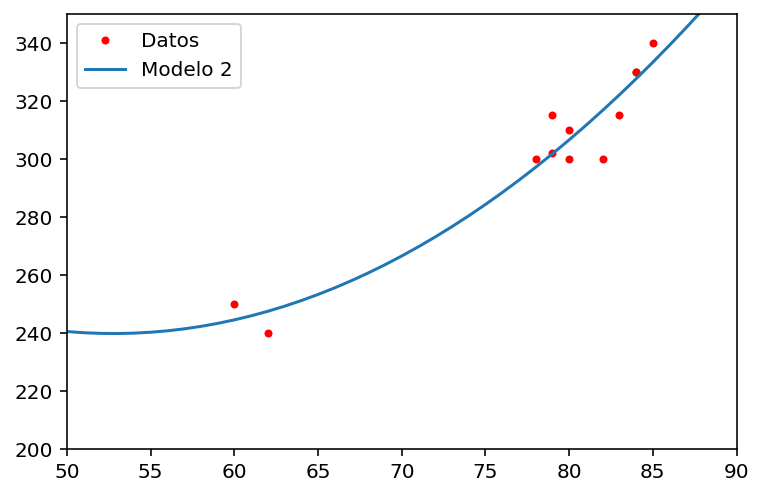

In [16]:
model_2 = LinearRegression(fit_intercept = False)
model_2.fit(x_2, y)

x_p = [[i] for i in range(50, 91)]
y_2 = model_2.predict(poly_2.fit_transform(x_p))

plot(x, y, 'r.', label = 'Datos')
plot(x_p, y_2, label = 'Modelo 2')
axis([50, 90, 200, 350])
legend(loc = 2)

En valor de $R^2$ es mejor para el modelo de grado dos. Se puede probar como mejora el valor a medida que se aumenta el grado del polinomio.

In [17]:
for d in range(1, 12):
    poly  = PolynomialFeatures(degree = d)
    p_x   = poly.fit_transform(x)
    model = LinearRegression(fit_intercept = False).fit(p_x, y)
    
    print("El R^2 para el polinomio de grado", d, "es", model.score(p_x, y))

El R^2 para el polinomio de grado 1 es 0.9101048533632331
El R^2 para el polinomio de grado 2 es 0.9287133420705341
El R^2 para el polinomio de grado 3 es 0.9290165340354674
El R^2 para el polinomio de grado 4 es 0.9689083191484311
El R^2 para el polinomio de grado 5 es 0.9691288938530828
El R^2 para el polinomio de grado 6 es 0.9690869704166272
El R^2 para el polinomio de grado 7 es 0.9690984839994046
El R^2 para el polinomio de grado 8 es 0.9691686371689322
El R^2 para el polinomio de grado 9 es 0.9693043693909861
El R^2 para el polinomio de grado 10 es 0.9695159803649102
El R^2 para el polinomio de grado 11 es 0.9698189285152242


El valor $R^2$ mejora claramente con el grado, pero esto puede ser debido a la existencia de sobreajuste. Debido a que los modelos tienen más grados de libertad, estos pueden memorizar los datos. La mejor manera de comprobar esto es gráficamente.

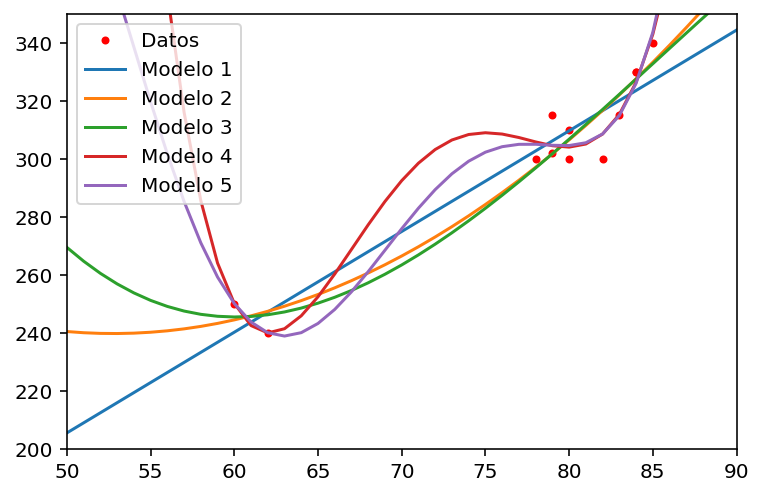

In [18]:
plot(x, y, 'r.', label = 'Datos')
x_p = [[i] for i in range(50, 91)]

for d in range(1, 6):
    poly  = PolynomialFeatures(degree = d)
    p_x   = poly.fit_transform(x)
    model = LinearRegression(fit_intercept = False).fit(p_x, y)
    p_y   = model.predict(poly.fit_transform(x_p))
    
    plot(x_p, p_y, label = "Modelo %d" % d)
    
axis([50, 90, 200, 350])

legend(loc = 2)

Obviamente en este ejemplo se puede observar claramente la existencia de sobreajuste los modelos con grado superior a dos.

## Validación fuera de muestra

La validación fuera de muestra requiere disponer de un conjunto de datos que se pueda dividir en un conjunto de entrenamiento y otro de validación con una cantidad de datos significativa. Para esto se va a utilizar el conjunto de datos de la vivienda de Boston que se encuentra entre los ejemplos que contiene scikit-learn.

En primer lugar se han de importar los datos para realizar un modelo de regresión.

In [19]:
from sklearn.datasets import load_boston

# Importación de los datos de vienda de Boston
boston = load_boston()

# Creación de un modelo 
model_boston = LinearRegression()
model_boston.fit(boston.data, boston.target)

print("R^2:", model_boston.score(boston.data, boston.target))

R^2: 0.7406426641094095


En este caso no se puede saber si existe o no sobreajuste. Para evaluarlo se puede dividir el conjunto en dos, uno de entrenamiento y otro de validación utilizando el método `train_test_split`. En esta función se puede utilizar el comando random_state para garantizar la receptibilidad de los resultados.

In [20]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state = 0)

# Creación de un modelo
model = LinearRegression()
model.fit(x_train, y_train)

predit_train = model.predict(x_train)
predit_test = model.predict(x_test)

# Evaluación de R2
print('R^2 en entrenamiento es: ', model.score(x_train, y_train))
print('R^2 en validación es: ', model.score(x_test, y_test))

R^2 en entrenamiento es:  0.7697699488741149
R^2 en validación es:  0.6354638433202129


El resultado se puede comprobar con otro valor de `random_state` observándose que el resultado puede cambiar considerablemente. 

In [21]:
x_train, x_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state = 1)

# Creación de un modelo
model = LinearRegression()
model.fit(x_train, y_train)

predit_train = model.predict(x_train)
predit_test = model.predict(x_test)

# Evaluación de R2
print('R^2 en entrenamiento es: ', model.score(x_train, y_train))
print('R^2 en validación es: ', model.score(x_test, y_test))

R^2 en entrenamiento es:  0.7168057552393374
R^2 en validación es:  0.7789410172622865


En estos casos se puede utilizar la validación cruzada en la que se divide el conjunto de datos en una cantidad dada. Se entrena el modelo con todos menos uno y se valida con este. Esto se puede realizar en con

In [22]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(LinearRegression(), boston.data, boston.target,
                            return_train_score = True,
                            cv = 5)
cv_results

{'fit_time': array([0.00111794, 0.0007    , 0.00058985, 0.00054812, 0.00054789]),
 'score_time': array([0.00079513, 0.00050187, 0.00048399, 0.00047684, 0.00047517]),
 'test_score': array([ 0.63919994,  0.71386698,  0.58702344,  0.07923081, -0.25294154]),
 'train_score': array([0.74652533, 0.72763185, 0.69498059, 0.84181027, 0.73545537])}

## Métricas de rendimiento para modelos de clasificación binarios
En los problemas de clasificación de clase binarios, en la que los resultados se etiquetan positivos (P) o negativos (N), hay cuatro posibles resultados que se pueden obtener:
* Verdaderos Positivos (TP)
* Verdaderos Negativos (TN)
* Falsos Positivos (FP) o Error tipo I
* Falsos Negativos (FN) o Error de tipo II

Para facilitar el análisis, los resultados se pueden organizar en una matriz de confusión:

$$
\left|
\begin{array}{cc}
TP & FP \\
FN & TN \\
\end{array}
\right|
$$

A partir de estos resultados se pueden construir diferentes métricas para evaluarla calidad de los modelos construidos, algunas de las más utilizadas son:
* Precisión (Accuracy): $A = \frac{TP + TN}{TP + FP + TN + FN}$
* Exactitud (Precision): $P = \frac{TP}{TP + FP}$
* Exhaustividad (Recall): $R = \frac{TP}{TP + FN}$
* Área bajo la curva ROC (ROC AUC)

En *scikit-learn* todas estas métricas se encuentran en la librería `metrics`. Se pueden probar en un conjunto de datos conocido.

La matriz de confusión es 
[[5 2]
 [3 6]]
Precisión: 0.6875
Exactitud: 0.75
Exhaustividad: 0.6666666666666666
AUC: 0.6904761904761905


Text(0.5, 1.0, 'AUC = 0.69')

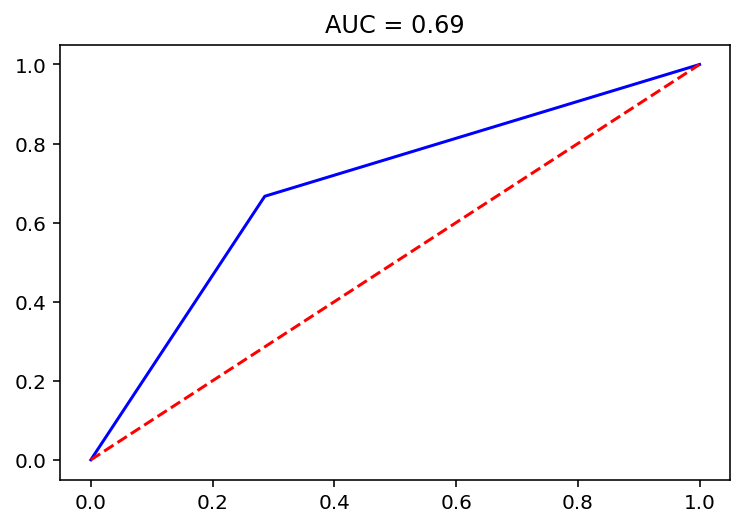

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_true = [0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
y_pred = [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1]

print(u'La matriz de confusión es ')
print(confusion_matrix(y_true, y_pred))

print(u'Precisión:', accuracy_score(y_true, y_pred))
print(u'Exactitud:', precision_score(y_true, y_pred))
print(u'Exhaustividad:', recall_score(y_true, y_pred))

false_positive_rate, recall, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(false_positive_rate, recall)

print(u'AUC:', roc_auc)

plot(false_positive_rate, recall, 'b')
plot([0, 1], [0, 1], 'r--')
title(u'AUC = %0.2f' % roc_auc)

En este ejemplo se puede ver que los la precisión del modelo es de 69%, 11 aciertos de 16 casos. La exactitud es 75%, 6 aciertos positivos para 8 positivos identificados por el modelo. La exhaustividad es de 66 %, 6 aciertos positivos para 9 que positivos existen en los datos.

A la hora de evaluar la calidad de los modelos este proceso va a ser necesario repetir este proceso, por lo que puede ser una buena idea crear una función que permita repetir el proceso de una forma rápida. 

La matriz de confusión es 
[[5 2]
 [3 6]]
Precisión: 0.6875
Exactitud: 0.75
Exhaustividad: 0.6666666666666666
AUC: 0.6904761904761905


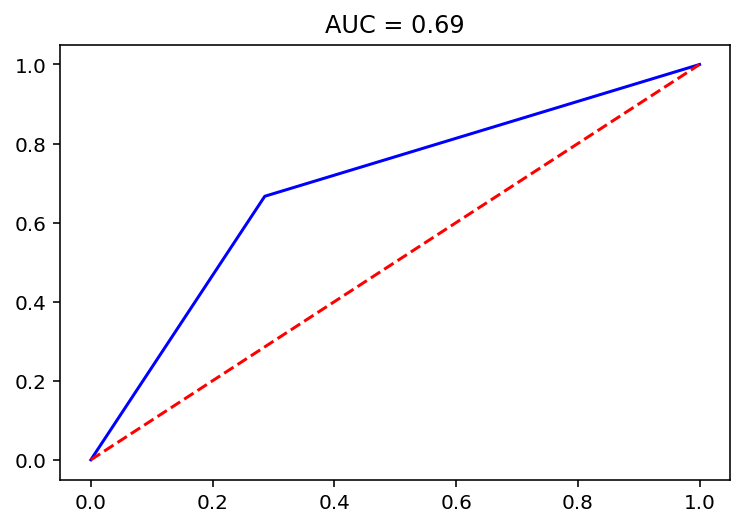

In [24]:
def metricas(y_true, y_pred):
    print(u'La matriz de confusión es ')
    print(confusion_matrix(y_true, y_pred))

    print(u'Precisión:', accuracy_score(y_true, y_pred))
    print(u'Exactitud:', precision_score(y_true, y_pred))
    print(u'Exhaustividad:', recall_score(y_true, y_pred))

    false_positive_rate, recall, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(false_positive_rate, recall)

    print(u'AUC:', roc_auc)

    plot(false_positive_rate, recall, 'b')
    plot([0, 1], [0, 1], 'r--')
    title(u'AUC = %0.2f' % roc_auc)
    
metricas(y_true, y_pred)

## Preparación de un conjunto de datos de ejemplo
En el resto de la unidad se va a utilizar un conjunto de datos de ejemplo generado con el método `make_classification`. En este caso se van a generar 2500 muestras con 10 características.

Posteriormente los resultados se van a separar en un conjunto de entrenamiento y test con el método ` train_test_split`.

In [25]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples = 2500,
                           n_features = 10,
                           n_redundant = 0,
                           random_state = 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

## Creación de modelos de clasificación: Regresión logística
La clasificación binaria de eventos se puede realizar a partir de un modelo regresión logística donde se utiliza la expresión:
$$
F(x) = \frac{1}{1 + e^{\sum-w_ix_i}}
$$

En *scikit-learn* el constructor con el que se puede crear un modelo de regresión logística es `LogisticRegression`. A modo de ejemplo se puede crear y evaluar para para el conjunto de datos generado previamente.

La matriz de confusión es 
[[838  92]
 [ 62 883]]
Precisión: 0.9178666666666667
Exactitud: 0.9056410256410257
Exhaustividad: 0.9343915343915344
AUC: 0.9177334016043693


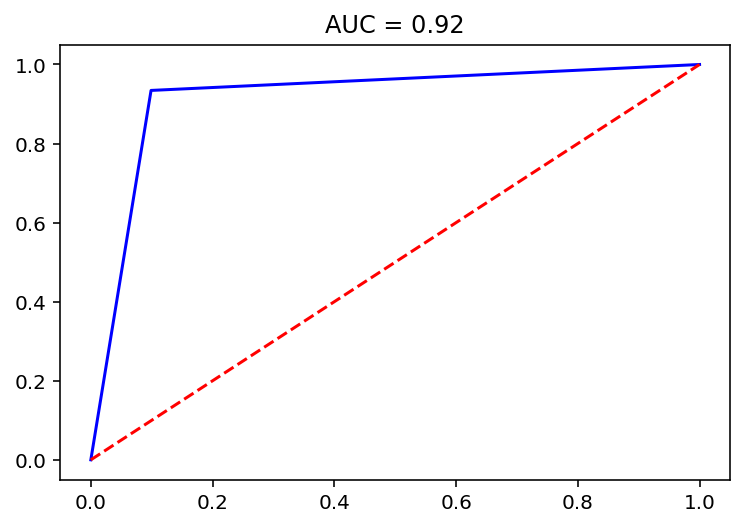

In [26]:
from sklearn.linear_model import LogisticRegression

lr_classifier = LogisticRegression(solver='lbfgs').fit(X_train, y_train)
y_train_pred = lr_classifier.predict(X_train)

metricas(y_train, y_train_pred)

Al tener 10 características es necesario comprobar que no se ha creado un modelo sobreajustado, para ello se evaluar el rendimiento del modelo en el conjunto de datos de test.

La matriz de confusión es 
[[291  31]
 [ 15 288]]
Precisión: 0.9264
Exactitud: 0.9028213166144201
Exhaustividad: 0.9504950495049505
AUC: 0.9271108787897423


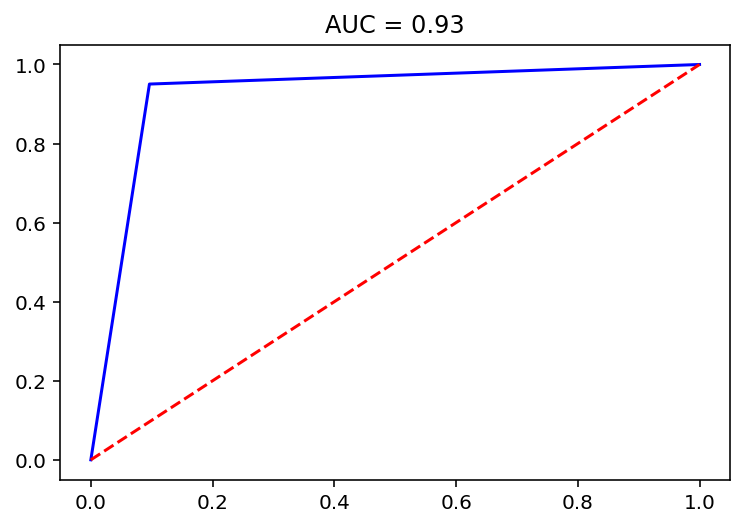

In [27]:
y_test_pred  = lr_classifier.predict(X_test)

metricas(y_test, y_test_pred)

En este ejemplo se puede observar que tanto el modelo en el conjunto de datos de entrenamiento y validación son similares, indicando que el modelo probablemente no se encuentre sobreajustado. En este caso se pude observar que la precisión es ligeramente superior en el conjunto de datos de validación, esto no es lo habitual, pero se puede observar debido a que existe una incertidumbre el valor por ser el conjunto una muestra de los datos.

### Modificación del criterio de predicción
En *scikit-learn* no existe una función que permita cambiar el criterio utilizado para decir si un registro es positivo o negativo. Lo que existe es un método de la clase `LogisticRegression` (`predict_proba`) con el que se puede obtener la probabilidad de que el registro sea positivo o negativo. A partir de esto se puede realizar una predicción con un umbral diferente.

Al llamar al método `predict_proba` se tiene:

In [28]:
lr_classifier.predict_proba(X_test)

array([[0.97750827, 0.02249173],
       [0.01926135, 0.98073865],
       [0.99692706, 0.00307294],
       ...,
       [0.01914597, 0.98085403],
       [0.02646548, 0.97353452],
       [0.46143196, 0.53856804]])

Una matriz en la que la primera columna es la probabilidad de que el registro sea falso y una segunda columna en la que tenían la probabilidad que te registro sea cierto. Con la segunda columna podemos realizar nuevas predicciones con diferentes umbrales. Podemos ver que en el caso de utilizar el valor de 0,5 tendremos la predicción original

La matriz de confusión es 
[[291  31]
 [ 15 288]]
Precisión: 0.9264
Exactitud: 0.9028213166144201
Exhaustividad: 0.9504950495049505
AUC: 0.9271108787897423


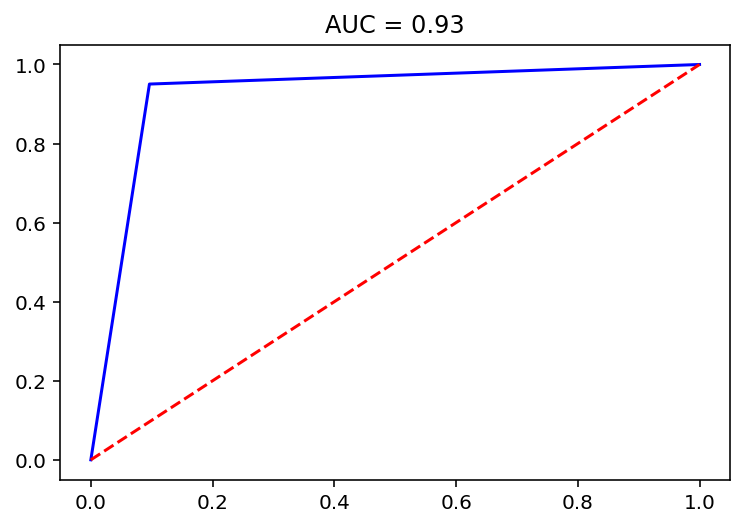

In [29]:
metricas(y_test, lr_classifier.predict_proba(X_test)[:,1] > 0.5)

En el caso de aumentar el umbral a 0,7 tendremos una menor precisión, una mayor exactitud a costa de una menor exhaustividad.

La matriz de confusión es 
[[299  23]
 [ 33 270]]
Precisión: 0.9104
Exactitud: 0.9215017064846417
Exhaustividad: 0.8910891089108911
AUC: 0.9098302687411599


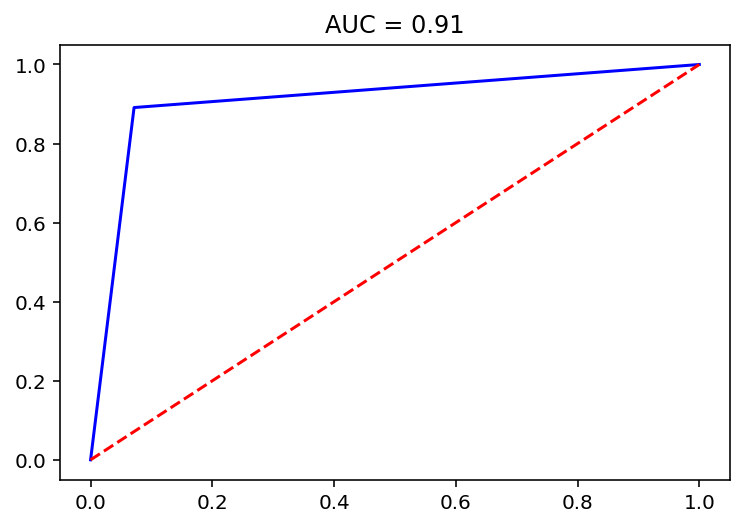

In [29]:
metricas(y_test, lr_classifier.predict_proba(X_test)[:,1] > 0.7)

Por otro lado, el caso de bajar el valor a 0,3 ocurrirá justamente lo contrario con los valores de la exactitud y exhaustividad.